<a href="https://colab.research.google.com/github/shivamsingla01/Movie-Genre-Prediction/blob/main/Movie_Genre_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify This Movie

### Imports

In [ ]:
from fastai.vision import *
from fastai import *
from sklearn.metrics import f1_score

### Defining evaluation metric

In [ ]:
def F1(y_pred, y):
    y_pred = y_pred.softmax(dim=1) 
    y_pred = y_pred.argmax(dim=1)
    return torch.tensor(f1_score(y.cpu(), y_pred.cpu(), labels=list(range(10)), average='weighted'),device='cuda:0')

### Seeding

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

### Reading Data

In [ ]:
df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/sample_submission.csv')

NameError: name 'pd' is not defined

### Defining Learner 

In [ ]:
def create_learner(SIZE:int,bs:int):
    data = (ImageList.from_df(df = df, path = 'data/train_data', cols = 0,suffix = '.jpg')
           .split_by_rand_pct(seed = 2)
           .label_from_df()
           .transform(tfms = get_transforms(),size = (SIZE,SIZE))
           .databunch(bs = bs,num_workers = 4)).normalize(imagenet_stats)

    test_data = ImageList.from_df(test_df, path='data/test_data/',cols='id',suffix = '.jpg')
    data.add_test(test_data)
    learn = cnn_learner(data, models.resnet50, metrics=[F1 , accuracy])
    return learn

Run the cells above this in case your session got interrupted due to insufficent GPU Memory
### Creating Learner

In [ ]:
learn = create_learner(256,128).mixup().to_fp16()

### Visualizing Data

In [ ]:
learn.data.classes

['Action',
 'Adventure',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Horror',
 'Romance',
 'Sci-Fi',
 'Thriller']

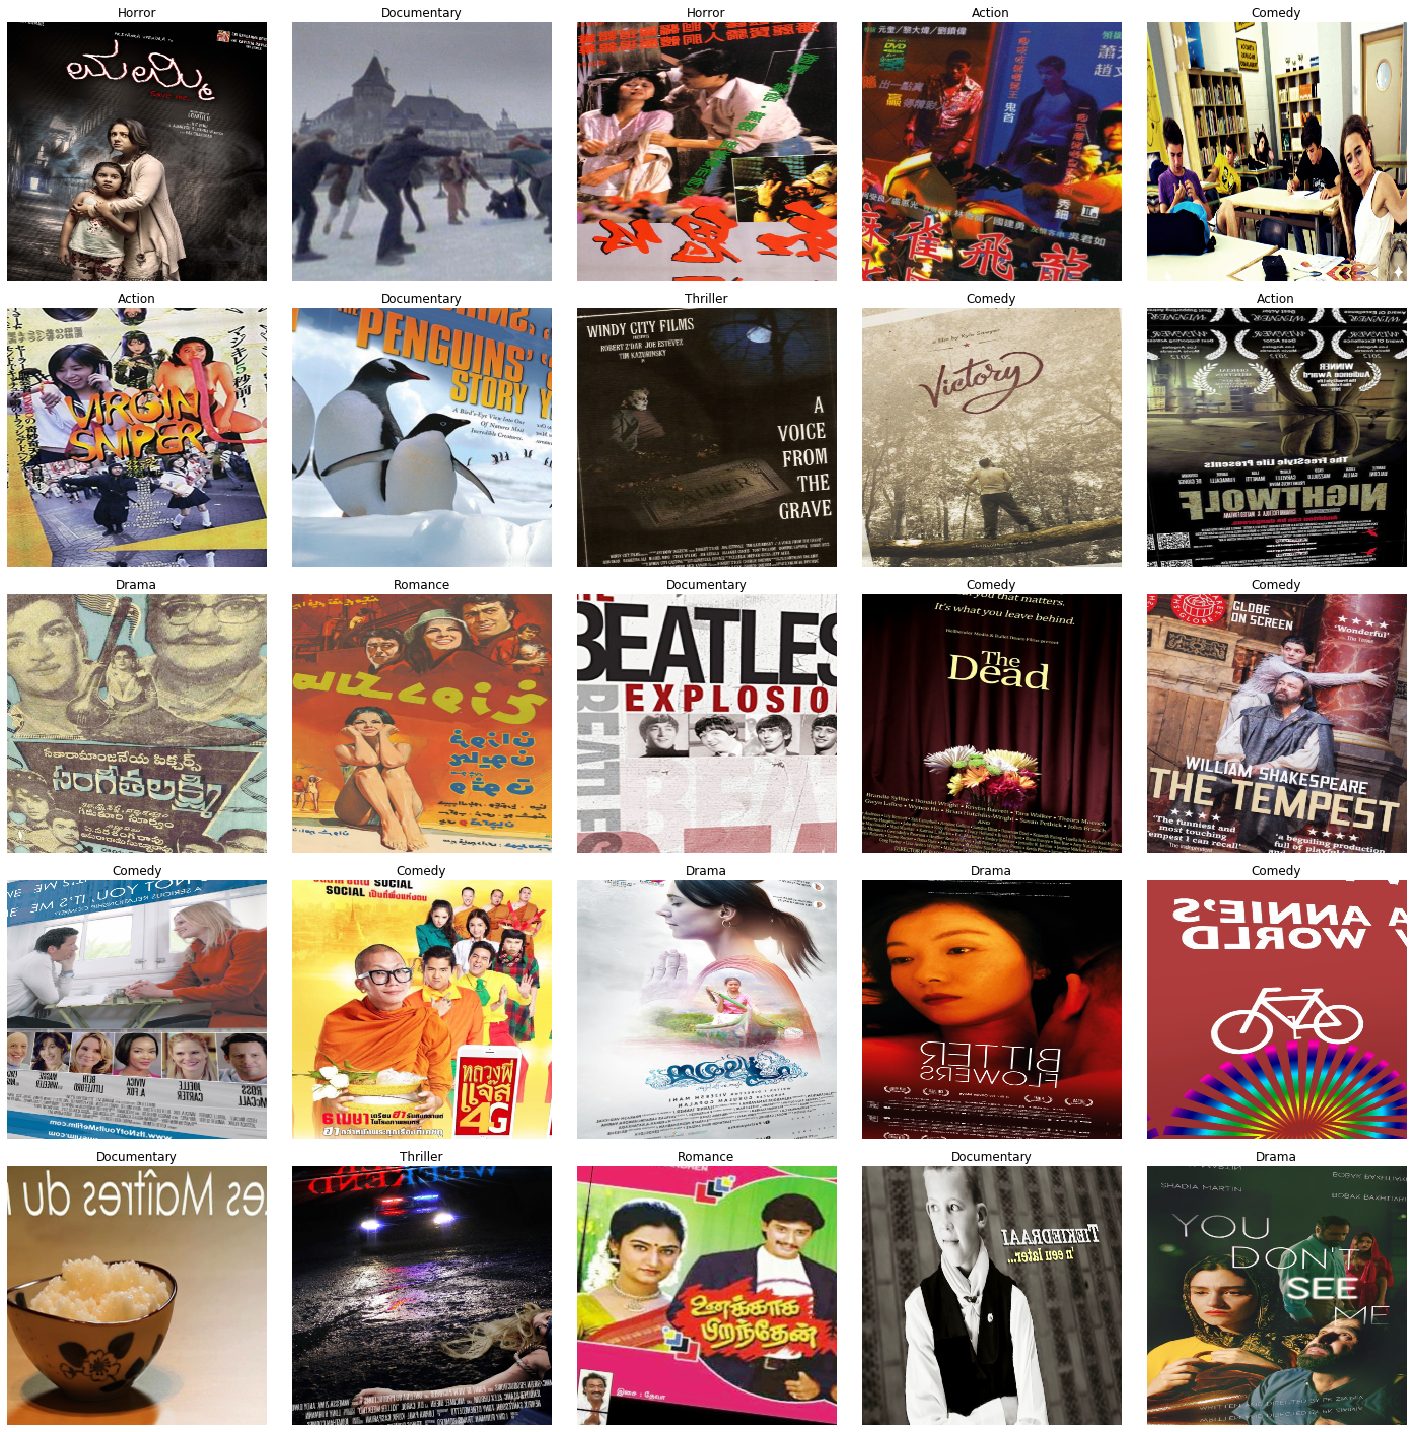

In [ ]:
learn.data.show_batch()

### Training 

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


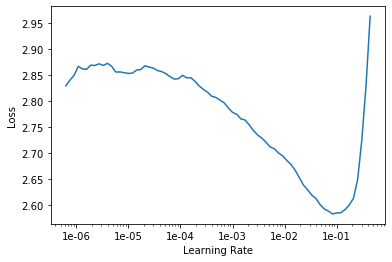

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(6,max_lr = 2e-3,callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='F1', name='stage-1')])

Better model found at epoch 0 with F1 value: 0.3077736496925354.


C:\Users\user\Anaconda3\envs\fastai_v1\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Better model found at epoch 1 with F1 value: 0.34059080481529236.
Better model found at epoch 2 with F1 value: 0.35698452591896057.
Better model found at epoch 3 with F1 value: 0.3822457194328308.
Better model found at epoch 4 with F1 value: 0.38998153805732727.


Although the apporoach should have been unfreezing and fine-tuning, I did not find much improvement in doing so. 
<div>So instead we go for the next step of training : <b>Progressive Resizing</b><div>
<div><a href= "https://arxiv.org/pdf/1804.09803.pdf">See here for more info</a></div>

### Creating new data with better resolution
#### Note : If running out of GPU Memory restart the kernel and run the first 4 cells (before <i><u>Creating Learner</u></i> heading) and then start from below

In [ ]:
learn.destroy()
learn = create_learner(512,32).mixup().to_fp16()

this Learner object self-destroyed - it still exists, but no longer usable


#### Reloading previous weights

In [ ]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (11976 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Comedy,Horror,Horror,Action,Comedy
Path: data\train_data;

Valid: LabelList (2993 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Adventure,Thriller,Drama,Drama,Crime
Path: data\train_data;

Test: LabelList (29996 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: data\train_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
  

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


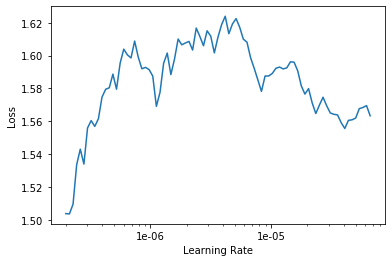

In [ ]:
learn.lr_find(end_lr = 1e-4)
learn.recorder.plot()

### Fine-tuning on higher resolution model

In [ ]:
learn.fit_one_cycle(16,max_lr = 1e-6,callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='F1', name='stage-2')])

C:\Users\user\Anaconda3\envs\fastai_v1\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Better model found at epoch 0 with F1 value: 0.37704983353614807.
Better model found at epoch 2 with F1 value: 0.3809768259525299.
Better model found at epoch 3 with F1 value: 0.38610175251960754.
Better model found at epoch 4 with F1 value: 0.3918079435825348.
Better model found at epoch 6 with F1 value: 0.3933315575122833.


KeyboardInterrupt: 

In [ ]:
learn.load('stage-2')

In [ ]:
data = (ImageList.from_df(df = df, path = 'data/train_data', cols = 0)
       .split_by_rand_pct(seed = 2)
       .label_from_df()
       .transform(tfms = get_transforms(),size = (512,512)) #squishing , not cropping
       .databunch(bs = 16,num_workers = 4)).normalize(imagenet_stats)


In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=[F1 , accuracy])

In [ ]:
learn.load('resnet50-squish-unf')

Learner(data=ImageDataBunch;

Train: LabelList (11976 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Comedy,Horror,Horror,Action,Comedy
Path: data\train_data;

Valid: LabelList (2993 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Adventure,Thriller,Drama,Drama,Crime
Path: data\train_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8,max_lr = 2e-6,callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='F1', name='resnet50-squish-64-sizeup'),
                                  callbacks.CSVLogger(learn, filename = 'resnet50-squish-64-sizeup')])

C:\Users\user\Anaconda3\envs\fastai_v1\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Better model found at epoch 0 with F1 value: 0.3993294835090637.
Better model found at epoch 1 with F1 value: 0.41217148303985596.
Better model found at epoch 2 with F1 value: 0.4145471155643463.
Better model found at epoch 3 with F1 value: 0.4216098487377167.
Better model found at epoch 7 with F1 value: 0.42200732231140137.


In [ ]:
learn.load('resnet50-squish-64-sizeup')

Learner(data=ImageDataBunch;

Train: LabelList (11976 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Comedy,Horror,Horror,Action,Comedy
Path: data\train_data;

Valid: LabelList (2993 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Adventure,Thriller,Drama,Drama,Crime
Path: data\train_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
learn.fit_one_cycle(8,max_lr = 2e-6,callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='F1', name='resnet50-squish-64-sizeup-16eps'),
                                  callbacks.CSVLogger(learn, filename = 'resnet50-squish-64-sizeup-16eps')])

C:\Users\user\Anaconda3\envs\fastai_v1\lib\site-packages\sklearn\metrics\_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Better model found at epoch 0 with F1 value: 0.4198175072669983.
Better model found at epoch 1 with F1 value: 0.42753592133522034.


In [ ]:
final_preds_cat = []
for idx in final_preds:
    final_preds_cat.append(cats[idx])
final_submit = pd.read_csv('data/sample_submission.csv')
final_submit.genres = final_preds_cat
final_submit.head()

id       genres
0  40464       Comedy
1  41406       Horror
2  70683  Documentary
3  34806       Comedy
4  64944       Comedy